# The Conjugate Gradient Method

> Notes from the Medical Vision Group's summer reading of _Numerical Optimization. J. Nocedal, Stephen J. Wright, 1999._

The goal of this notebook is
1. To derive the conjugate gradient method, and 
2. Explain the connection between eigenvalues and the convergence rate.

## Setup

The goal of the conjugate gradient algorithm is to iteratively solve linear systems of the form

$$Ax = b \,,$$

where **we assume that $A \in \mathbb{R}^{n \times n}$ is symmetric positive definite.**

It turns out that solving such a linear system is equivalent to minimizing the quadratic form

$$f(x) = x^TAx - b^Tx + c \,.$$

To see this, look at its gradient: 

$$\nabla f(x) = Ax - b \,.$$

The gradient equals zero exactly at $x=x^*$ that minimizes the the residual of the linear system $r(x) = Ax - b \,.$

To minimize the quadratic form, we _could_ use steepest descent, which is gradient descent where you take the largest step possible to minimize the loss. 
However, for certain linear systems, gradient descent converges very slowly (_slowly_ here means that the number of steps needed for convergence is $\gg n$, the dimension of $A$).
Instead, conjugate gradient gives an iterative optimization that is guaranteed to converge in at most $n$ steps (in exact arithmatic; floating point accuracy means it can take a little longer, but it's still faster than gradient descent).

## Understanding conjugacy

In essence, the conjugate gradient method is simply a change of basis.
However, the basis we seek is very special:
specifically, we are looking for a set of basis vectors that are _conjugate_ with respect to $A$.
Two vectors $u$ and $v$ are conjugate if they satisfy a special kind of orthogonality:

$$ u^T A v = v^T A v = 0 \,.$$

This means that after $u$ ($v$) is transformed by $A$, it is orthogonal to $v$ ($u$).

In [1]:
using LinearAlgebra
using Plots

In [2]:
# Sample a random PSD matrix
function random_psd(n::Int64=2)
    A = randn(n, 2)
    return A' * A
end

random_psd (generic function with 2 methods)

In [3]:
# Plot the level sets of the isoclines of a PSD matrix
function plot_ellipse(A::Matrix{Float64}; t=LinRange(0, 2π, 100), c=:gray)

    # Get the trace for the ellipse with radius 1
    trace_ellipse(t) = V' * @. sqrt(Λ) * [sin(t) cos(t)]'
    Λ, V = eigen(A)
    ellipse = trace_ellipse(t)
    ellipse_x, ellipse_y = [ellipse[i, :] for i in 1:length(Λ)]

    # Draw ellipses with many radii
    p = plot(ellipse_x, ellipse_y, c=c, legend=false, aspect_ratio=:equal)
    for r in LinRange(1, 1.75, 3)
        plot!(p, r .* ellipse_x, r .* ellipse_y, c=c)
    end
    
    # Draw the principle axes
    scaled_axes = V .* Λ'
    x1, x2 = [scaled_axes[:, i] for i in 1:length(Λ)]
    plot!(p, ([0, x1[1]], [0, x1[2]]))
    plot!(p, ([0, x2[1]], [0, x2[2]]))
    
    # Make the title the condition number
    λ₁, λ₂ = sort(Λ, rev=true)
    κ = λ₁ / λ₂ |> κ -> round(κ; digits=2)
    title!("κ=$κ")
    return p
end

plot_ellipse (generic function with 1 method)

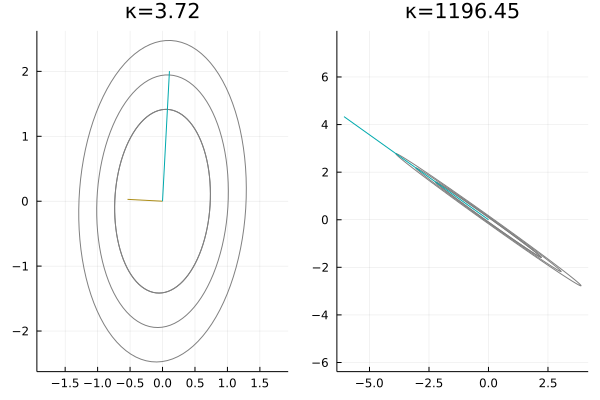

In [4]:
p1 = random_psd(2) |> plot_ellipse
p2 = random_psd(2) |> plot_ellipse
plot(p1, p2, layout=2)

## A basic implementation of conjugate gradients

In [2]:
function conjgrad1(A::Matrix{Float64}, b::Vector{Float64}, x::Vector{Float64})

    r = A * x - b
    p = -r

    k = 1
    error = Float64[]

    while norm(r) > 10e-6
        push!(error, norm(r))
        α = -(r' * p) / (p' * A * p)
        x = x + α * p
        r = A * x - b
        β = (r' * A * p) / (p' * A * p)
        p = -r + β * p
        k += 1
    end
    
    return x, k, error

end

conjgrad1 (generic function with 1 method)

In [3]:
function conjgrad2(A::Matrix{Float64}, b::Vector{Float64}, x::Vector{Float64})
    
    r = A * x - b
    p = -r
    
    k = 1
    error = Float64[]

    while norm(r) > 10e-6
        push!(error, norm(r))
        α = (r' * r) / (p' * A * p)
        x = x + α * p
        
        r_old = deepcopy(r)
        r = r_old + α * A * p
        
        β = (r' * r) / (r_old' * r_old)
        p = -r + β * p
        k += 1
    end
    
    return x, k, error

end

conjgrad2 (generic function with 1 method)

In [4]:
A(n::Int64) = [1 / (i + j - 1) for i=1:n, j=1:n]  # Hilbert matrix
b(n::Int64) = ones(n)  # Target
x(n::Int64) = zeros(n)  # Initial guess

x (generic function with 1 method)

In [5]:
using BenchmarkTools

for n in [5, 8, 12, 20]
    @show n
    _, k₁, _ = @btime conjgrad1(A($n), b($n), x($n))
    _, k₂, _ = @btime conjgrad2(A($n), b($n), x($n))
    @show k₁, k₂
end

n = 5
  2.241 μs (68 allocations: 6.48 KiB)
  2.051 μs (74 allocations: 7.89 KiB)
(k₁, k₂) = (7, 7)
n = 8
  10.791 μs (289 allocations: 36.66 KiB)
  6.842 μs (218 allocations: 29.27 KiB)
(k₁, k₂) = (29, 20)
n = 12
  15.083 μs (319 allocations: 50.91 KiB)
  9.000 μs (240 allocations: 38.89 KiB)
(k₁, k₂) = (32, 22)
n = 20
  53.750 μs (730 allocations: 163.77 KiB)
  21.333 μs (383 allocations: 82.91 KiB)
(k₁, k₂) = (73, 35)


## Clustered eigenvalues

In [6]:
# Really look into clustered eigenvalues
# Is the rate of progress related to eigenvalue clusters?
using Plots

In [7]:
m = 10
S = randn(m, m)
uniform = S * diagm(1:m) / S
clust_2 = S * diagm([0.9, 1., 1.1, 1.5, 2.1, 28.8, 28.9, 29.2, 29.3, 210.1]) / S
clust_3 = S * diagm([0.9, 1., 1.1, 5.5, 5.8, 26.1, 28.9, 29.2, 29.3, 210.1]) / S ;

In [8]:
_, _, error = conjgrad2(uniform, b(m), x(m))
plot(error, label="uniform")

_, _, error = conjgrad2(clust_2, b(m), x(m))
plot!(error, label="clust_2")

_, _, error = conjgrad2(clust_3, b(m), x(m))
plot!(error, label="clust_3")

LoadError: InterruptException: